In [1]:
! pip install tensorflow matplotlib shutil

ERROR: Could not find a version that satisfies the requirement shutil (from versions: none)
ERROR: No matching distribution found for shutil


In [2]:
import os
import json
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Paths to your dataset directories
dataset_dirs = {
    'train': r'C:\Users\Priyamvadha Pradeep\Desktop\Image Lab\BCCD\dataset\train',
    'valid': r'C:\Users\Priyamvadha Pradeep\Desktop\Image Lab\BCCD\dataset\valid',
    'test': r'C:\Users\Priyamvadha Pradeep\Desktop\Image Lab\BCCD\dataset\test'
}

def organize_images_from_json(dataset_dir):
    # Path to the JSON file in each directory
    json_file = os.path.join(dataset_dir, 'labels.json')  # Ensure labels.json exists in each folder
    if not os.path.exists(json_file):
        print(f"Error: {json_file} does not exist.")
        return
    
    # Load the JSON file
    with open(json_file, 'r') as f:
        data = json.load(f)

    # Parse categories (to map category ID to category name)
    categories = {category['id']: category['name'] for category in data['categories']}

    # Parse annotations (to map image_id to their labels)
    image_annotations = {}
    for annotation in data.get('annotations', []):
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        image_annotations.setdefault(image_id, []).append(categories[category_id])

    # Map image IDs to file names
    image_mapping = {image['id']: image['file_name'] for image in data['images']}
    
    # Create class folders and move images
    for image_id, labels in image_annotations.items():
        # Use the first label for organizing (if you want to allow multiple categories, adjust accordingly)
        primary_label = labels[0]
        src = os.path.join(dataset_dir, image_mapping[image_id])  # Original image path
        class_dir = os.path.join(dataset_dir, primary_label)  # Target directory for the label
        
        # Create the class directory if it doesn't exist
        os.makedirs(class_dir, exist_ok=True)
        
        # Move the image to the target directory
        if os.path.exists(src):
            shutil.move(src, os.path.join(class_dir, image_mapping[image_id]))
        else:
            print(f"Warning: Image {src} not found.")

# Apply the function to each dataset split
for split, dir_path in dataset_dirs.items():
    print(f"Organizing images in {split} directory...")
    organize_images_from_json(dir_path)
    print(f"Completed organizing {split} directory.")


Organizing images in train directory...
Completed organizing train directory.
Organizing images in valid directory...
Completed organizing valid directory.
Organizing images in test directory...
Completed organizing test directory.


In [4]:
# a. Load the dataset
dataset_dir = r'C:\Users\Priyamvadha Pradeep\Desktop\Image Lab\BCCD\dataset'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'valid')

In [5]:
# b. Show the number of training and testing images
num_train_images = sum([len(files) for r, d, files in os.walk(train_dir)])
num_val_images = sum([len(files) for r, d, files in os.walk(val_dir)])

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")

Number of training images: 256
Number of validation images: 74


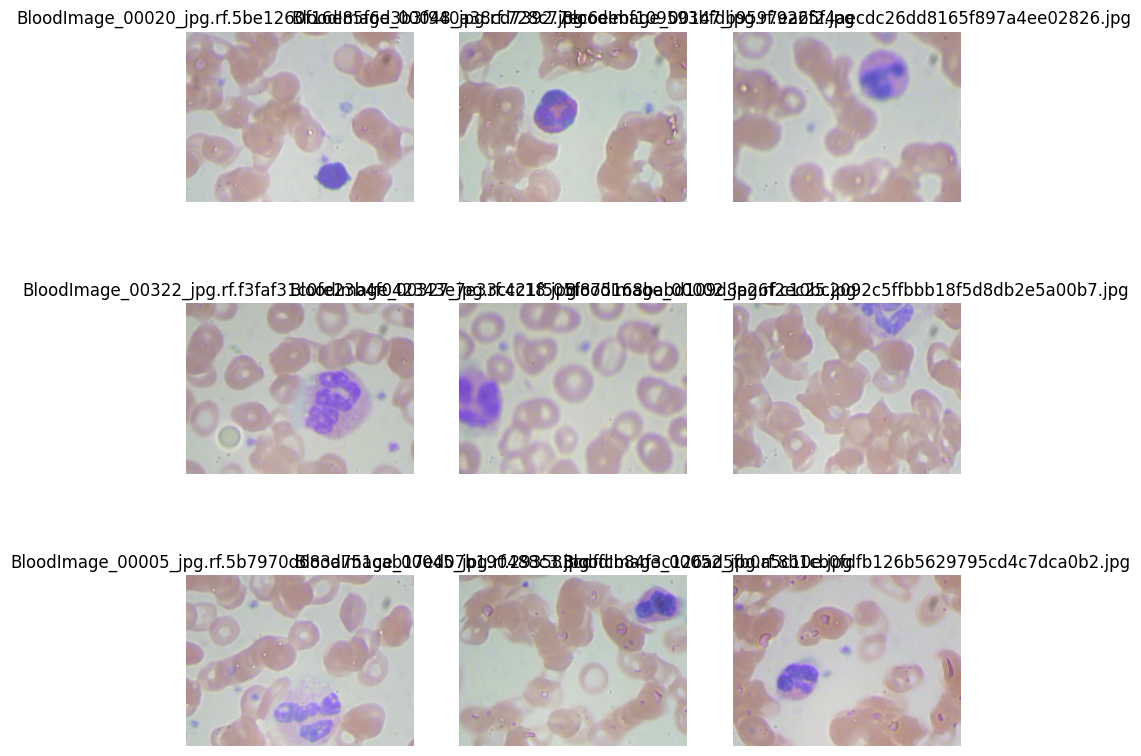

In [6]:
def plot_images_from_directory(directory, num_images=9):
    plt.figure(figsize=(10, 10))
    image_count = 0

    for root, _, files in os.walk(directory):
        for file in files:
            # Skip non-image files like labels.json
            if not (file.endswith('.jpg') or file.endswith('.png')):
                continue

            # Load and display image
            if image_count >= num_images:
                break
            img = Image.open(os.path.join(root, file))
            ax = plt.subplot(3, 3, image_count + 1)
            plt.imshow(img)
            plt.title(f"{file}")
            plt.axis("off")
            image_count += 1
        
        if image_count >= num_images:
            break

    plt.show()

# Call the function for your 'train' directory
train_dir = r'C:\Users\Priyamvadha Pradeep\Desktop\Image Lab\BCCD\dataset\train'
plot_images_from_directory(train_dir)

In [7]:
# d. Image augmentation – contrast, flipping, and rotation

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,       # Rotation
    horizontal_flip=True,    # Horizontal flipping
    brightness_range=[0.8, 1.2]  # Contrast adjustment
)

val_datagen = ImageDataGenerator(rescale=1.0/255)  # Just rescaling for validation

# Loading augmented images from the directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 255 images belonging to 3 classes.
Found 73 images belonging to 3 classes.


In [8]:
# e. After augmentation, show the number of training and testing images
print(f"Number of augmented training images (on-the-fly): {num_train_images}")
print(f"Number of augmented validation images (on-the-fly): {num_val_images}")

Number of augmented training images (on-the-fly): 256
Number of augmented validation images (on-the-fly): 74


In [9]:
# f. Normalizing the training data is already handled in the ImageDataGenerator with `rescale=1.0/255`

In [10]:
# g. Build a convolutional neural network for initial training without augmentation
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 classes: WBC, RBC, Platelets
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the CNN model (without augmentation)
history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.6880 - loss: 1.0039

c:\Users\Priyamvadha Pradeep\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.6891 - loss: 0.9892 - val_accuracy: 0.8630 - val_loss: 0.5201
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.7976 - loss: 0.5826 - val_accuracy: 0.8630 - val_loss: 0.5219
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 369ms/step - accuracy: 0.7669 - loss: 0.6854 - val_accuracy: 0.8630 - val_loss: 0.5345
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.7976 - loss: 0.5847 - val_accuracy: 0.8630 - val_loss: 0.5285
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.8129 - loss: 0.5380 - val_accuracy: 0.8630 - val_loss: 0.5188
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.8068 - loss: 0.5581 - val_accuracy: 0.8630 - val_loss: 0.5302
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.8243 - loss: 0.5397 - val_accuracy: 0.8630 - val_loss: 0.5212
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - accuracy: 0.8134 - loss: 0.5623 - val_accuracy: 0.8630 - val_loss: 0.5422
Epo

In [11]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,915,083 (37.82 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,610,056 (25.22 MB)

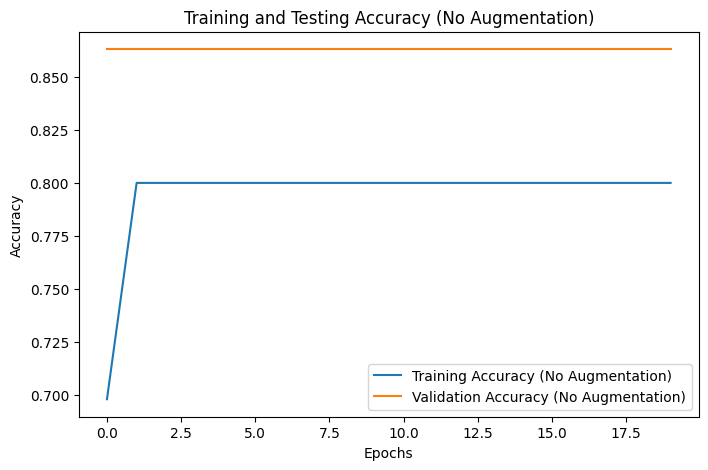

In [12]:
# h. Show the training and testing accuracy (without augmentation)
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy (No Augmentation)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (No Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy (No Augmentation)')
plt.show()

In [13]:
# i. Build a convolutional neural network to train images with augmentation
# We'll use the same model architecture but train with augmented images this time

augmented_history = cnn_model.fit(
    train_data,
    validation_data=val_data,
    epochs=20
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.8133 - loss: 0.5592 - val_accuracy: 0.8630 - val_loss: 0.5203
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.7878 - loss: 0.5757 - val_accuracy: 0.8630 - val_loss: 0.5262
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 349ms/step - accuracy: 0.8081 - loss: 0.5598 - val_accuracy: 0.8630 - val_loss: 0.5390
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 347ms/step - accuracy: 0.7770 - loss: 0.5901 - val_accuracy: 0.8630 - val_loss: 0.5539
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.8177 - loss: 0.5272 - val_accuracy: 0.8219 - val_loss: 0.5921
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.7981 - loss: 0.5980 - val_accuracy: 0.8630 - val_loss: 0.5412
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 343ms/step - accuracy: 0.8212 - loss: 0.5225 - val_accuracy: 0.8630 - val_loss: 0.5500
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - accuracy: 0.8001 - loss: 0.5452 - val_accuracy: 0.8630 - val_loss:

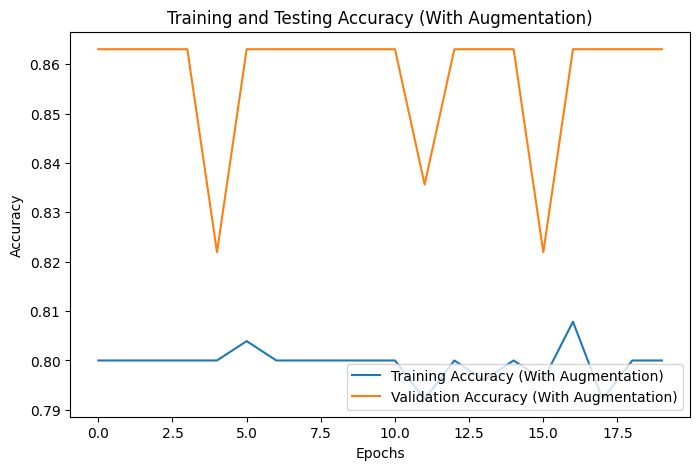

In [14]:
# j. Show the training and testing accuracy (with augmentation)
plt.figure(figsize=(8, 5))
plt.plot(augmented_history.history['accuracy'], label='Training Accuracy (With Augmentation)')
plt.plot(augmented_history.history['val_accuracy'], label='Validation Accuracy (With Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy (With Augmentation)')
plt.show()

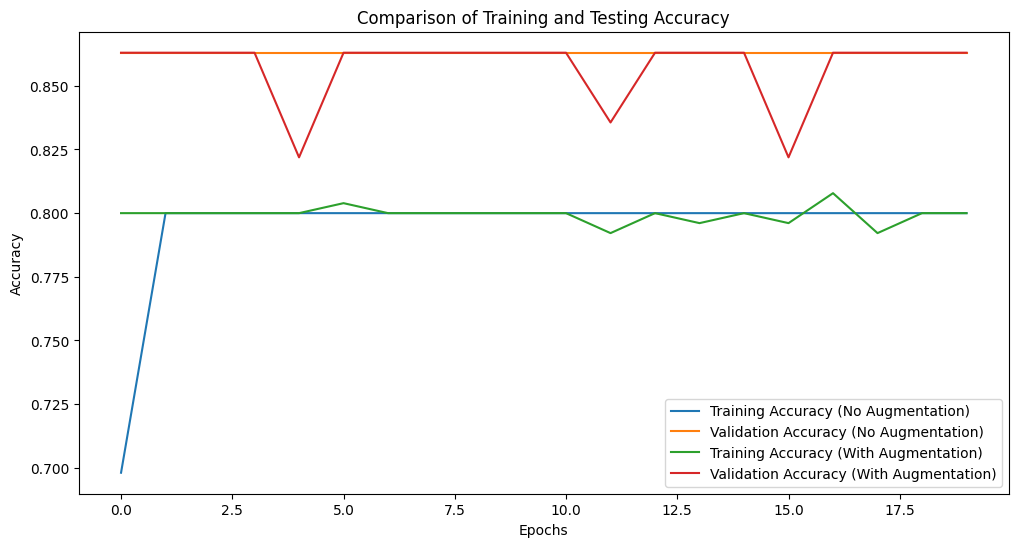

In [15]:
# k. Compare the training and testing accuracy before and after augmentation
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy (No Augmentation)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (No Augmentation)')
plt.plot(augmented_history.history['accuracy'], label='Training Accuracy (With Augmentation)')
plt.plot(augmented_history.history['val_accuracy'], label='Validation Accuracy (With Augmentation)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Comparison of Training and Testing Accuracy')
plt.show()

In [16]:
# Print training and validation accuracy for the model without augmentation
print("Training Accuracy (No Augmentation):", history.history['accuracy'][-1])
print("Validation Accuracy (No Augmentation):", history.history['val_accuracy'][-1])
print("Training Loss (No Augmentation):", history.history['loss'][-1])
print("Validation Loss (No Augmentation):", history.history['val_loss'][-1])

# Print training and validation accuracy for the model with augmentation
print("Training Accuracy (With Augmentation):", augmented_history.history['accuracy'][-1])
print("Validation Accuracy (With Augmentation):", augmented_history.history['val_accuracy'][-1])
print("Training Loss (With Augmentation):", augmented_history.history['loss'][-1])
print("Validation Loss (With Augmentation):", augmented_history.history['val_loss'][-1])

Training Accuracy (No Augmentation): 0.800000011920929
Validation Accuracy (No Augmentation): 0.8630136847496033
Training Loss (No Augmentation): 0.5599442720413208
Validation Loss (No Augmentation): 0.5328447818756104
Training Accuracy (With Augmentation): 0.800000011920929
Validation Accuracy (With Augmentation): 0.8630136847496033
Training Loss (With Augmentation): 0.4866192936897278
Validation Loss (With Augmentation): 0.5432859063148499
